In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 300)
np.random.seed(42)

# Loading Data

In [2]:
train_df, valid_df = train_test_split(
    pd.read_csv("./data/train.csv"),
    test_size = 0.25,
    random_state = 42
)
train_df = train_df.set_index("row_id")
train_df.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag
row_id,,,,,,,,,,,,,,,,,
28196,1,2019-08-05 00:00:00+08:00,22779,55,6,14,21,2,5,7,13,31,60,0,4,5,0
72595,1,2019-09-02 00:00:00+08:00,97681,33,69,4,Never checkout,0,0,0,7,30,35,4,14,14,0
11483,4,2019-07-23 00:00:00+08:00,92806,48,4,9,155,3,5,6,9,28,65,0,0,0,1
28515,1,2019-08-05 00:00:00+08:00,37990,55,13,6,11,0,0,0,12,45,89,0,5,7,0
62755,1,2019-08-28 00:00:00+08:00,23627,50,61,5,32,0,0,0,9,52,70,0,2,9,0


In [3]:
valid_df = valid_df.set_index("row_id")
valid_df.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag
row_id,,,,,,,,,,,,,,,,,
11995,3,2019-07-23 00:00:00+08:00,113696,39,Never open,11,24,0,0,0,0,6,6,0,1,1,0
69852,1,2019-09-02 00:00:00+08:00,5375,33,97,2,2,0,0,0,11,19,70,1,1,2,0
7149,2,2019-07-21 00:00:00+08:00,32645,43,58,2,10,0,0,1,25,76,149,1,4,10,0
4449,2,2019-07-18 00:00:00+08:00,103814,52,3,12,78,4,17,30,0,8,10,0,0,0,1
36644,3,2019-08-08 00:00:00+08:00,117490,52,Never open,21,Never checkout,3,3,3,0,1,1,0,0,0,0


In [4]:
test_df = pd.read_csv("./data/test.csv")
test_df = test_df.set_index("row_id")
test_df.head()

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days
row_id,,,,,,,,,,,,,,,,
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,10,34,134,0,6,18
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,5,5,5,0,0,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,13,19,38,2,2,2
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,43,110,173,2,5,5
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,4,12,39,0,0,2


In [5]:
users_df = pd.read_csv("./data/users.csv")
users_df = users_df.set_index("user_id")
users_df.head()

,attr_1,attr_2,attr_3,age,domain
user_id,,,,,
0,NaN,1.0,0.0,NaN,@gmail.com
1,1.0,1.0,2.0,50.0,@gmail.com
2,NaN,1.0,0.0,NaN,other
3,NaN,1.0,0.0,NaN,@gmail.com
4,1.0,1.0,2.0,33.0,@gmail.com


# Data Cleaning (Users)

In [6]:
users_df_clean = users_df.copy()

# Filling missing values
users_df_clean["attr_1"] = users_df_clean["attr_1"].fillna(1.0)
users_df_clean["attr_2"] = users_df_clean["attr_2"].fillna(1.0)

# Masking age
users_df_clean["age"] = users_df_clean["age"].mask((users_df_clean["age"] > 75) | (users_df_clean["age"] < 15))

# Converting domains to integers
domains = ['@gmail.com', 'other', '@yahoo.com', '@hotmail.com', '@ymail.com', '@live.com', '@icloud.com', '@outlook.com', '@rocketmail.com', '@qq.com', '@163.com']
domains_dict = {key: domains.index(key) for key in domains}
users_df_clean["domain"] = users_df_clean["domain"].map(lambda x: domains_dict[x])

# Predicting missing ages using KNN Regressor
# users_train_df = users_df_clean[users_df_clean["age"].notna()].astype(int)
# users_test_df = users_df_clean[users_df_clean["age"].isna()].drop("age", axis = 1).astype(int)

# knn = KNeighborsRegressor(n_neighbors = 7)
# knn.fit(users_train_df.drop("age", axis = 1).to_numpy(), users_train_df["age"].to_numpy())

# users_df_clean = users_train_df.copy()
# for key, group in users_test_df.groupby(["attr_1", "attr_2", "attr_3", "domain"]):
#     group = group.copy()
#     most_likely_age = knn.predict([np.array(key)])
#     std_dev = 5
#     group.loc[:, "age"] = np.rint(np.random.normal(most_likely_age, std_dev, len(group)))
#     users_df_clean = pd.concat([users_df_clean, group])

# Use Mean for missing ages
users_df_clean.loc[users_df_clean["age"].isna(), "age"] = round(users_df_clean[users_df_clean["age"].notna()].age.mean())
# users_df_clean.loc[users_df_clean["age"].isna(), "age"] = np.rint(np.random.normal(
#     users_df_clean[users_df_clean["age"].notna()].age.mean(), 5, len(users_df_clean[users_df_clean["age"].isna()])))

users_df_clean = users_df_clean.astype(int)
users_df_clean = users_df_clean.sort_index()
users_df_clean

,attr_1,attr_2,attr_3,age,domain
user_id,,,,,
0,1,1,0,31,0
1,1,1,2,50,0
2,1,1,0,31,1
3,1,1,0,31,0
4,1,1,2,33,0
...,...,...,...,...,...
127921,1,1,0,31,2
127922,1,1,0,20,0
127923,1,1,0,31,0


# Data Cleaning (Train)

In [7]:
def clean_data(df, users_df):
    tdf = df.copy()
    
    # Merge user attributes
    tdf = tdf.merge(users_df, on = "user_id")
    
    # Rename columns for convenience
    tdf = tdf.rename(columns = {
        "open_count_last_10_days": "open_10",
        "open_count_last_30_days": "open_30",
        "open_count_last_60_days": "open_60",
        "login_count_last_10_days": "login_10",
        "login_count_last_30_days": "login_30",
        "login_count_last_60_days": "login_60",
        "checkout_count_last_10_days": "checkout_10",
        "checkout_count_last_30_days": "checkout_30",
        "checkout_count_last_60_days": "checkout_60",
        "subject_line_length": "subject_len"
    })
    
    # Replace text with integers
    tdf["last_open_day"] = tdf["last_open_day"].replace("Never open", 
            tdf[tdf["last_open_day"] != "Never open"]["last_open_day"].astype(int).max() + 1)
    tdf["last_login_day"] = tdf["last_login_day"].replace("Never login", 
            tdf[tdf["last_login_day"] != "Never login"]["last_login_day"].astype(int).max() + 1)
    tdf["last_checkout_day"] = tdf["last_checkout_day"].replace("Never checkout", 
            tdf[tdf["last_checkout_day"] != "Never checkout"]["last_checkout_day"].astype(int).max() + 1)
    
    # Reset data types
    tdf["grass_date"] = pd.to_datetime(tdf["grass_date"]).dt.tz_localize(None)
    tdf.loc[:, tdf.columns != "grass_date"] = tdf.loc[:, tdf.columns != "grass_date"].astype(int)
    
#     # Fix dirty data in open_*, login_* and checkout_*
#     tdf.loc[((tdf["last_open_day"] > 10) & (tdf["open_10"] > 0)), "open_10"] = 0
#     tdf.loc[((tdf["last_open_day"] > 30) & (tdf["open_30"] > 0)), "open_30"] = 0
#     tdf.loc[((tdf["last_open_day"] > 60) & (tdf["open_60"] > 0)), "open_60"] = 0
    
#     tdf.loc[((tdf["last_login_day"] > 10) & (tdf["login_10"] > 0)), "login_10"] = 0
#     tdf.loc[((tdf["last_login_day"] > 30) & (tdf["login_30"] > 0)), "login_30"] = 0
#     tdf.loc[((tdf["last_login_day"] > 60) & (tdf["login_60"] > 0)), "login_60"] = 0
    
#     tdf.loc[((tdf["last_checkout_day"] > 10) & (tdf["checkout_10"] > 0)), "checkout_10"] = 0
#     tdf.loc[((tdf["last_checkout_day"] > 30) & (tdf["checkout_30"] > 0)), "checkout_30"] = 0
#     tdf.loc[((tdf["last_checkout_day"] > 60) & (tdf["checkout_60"] > 0)), "checkout_60"] = 0

    return tdf

train_df_clean = clean_data(train_df, users_df_clean)
train_df_clean

,country_code,grass_date,user_id,subject_len,last_open_day,last_login_day,last_checkout_day,open_10,open_30,open_60,login_10,login_30,login_60,checkout_10,checkout_30,checkout_60,open_flag,attr_1,attr_2,attr_3,age,domain
0,1,2019-08-05,22779,55,6,14,21,2,5,7,13,31,60,0,4,5,0,1,1,2,29,0
1,1,2019-09-02,97681,33,69,4,1446,0,0,0,7,30,35,4,14,14,0,1,1,0,31,0
2,4,2019-07-23,92806,48,4,9,155,3,5,6,9,28,65,0,0,0,1,1,1,1,44,3
3,1,2019-08-05,37990,55,13,6,11,0,0,0,12,45,89,0,5,7,0,1,1,1,24,0
4,1,2019-08-28,23627,50,61,5,32,0,0,0,9,52,70,0,2,9,0,1,1,0,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55149,3,2019-08-15,48651,39,23,65,68,1,2,4,2,3,3,0,0,0,1,1,1,2,29,0
55150,1,2019-08-09,44041,60,43,0,1,0,0,1,38,91,169,11,25,34,0,1,1,1,45,0
55151,1,2019-07-20,22645,46,91,2,23,0,0,0,41,106,160,4,8,10,0,1,1,2,21,0
55152,1,2019-08-22,19737,61,121,1,52,0,0,0,12,40,96,0,0,2,0,1,1,1,28,0


# Feature Engineering

In [8]:
def one_hot_encoding(x, vals, prefix = ""):
    one_hot = dict()
    for val in vals:
        one_hot["{}_{}".format(prefix, val)] = x.map(lambda x: 1 if x == val else 0)
    return pd.DataFrame(one_hot)
    
def engineer_features(df, is_valid = False):
    tdf = df.copy()
    
    # Remove user_id feature
    tdf = tdf.drop("user_id", axis = 1)

    # Extract date features
    tdf["day"] = tdf["grass_date"].map(lambda x: x.day)
    tdf["grass_month"] = tdf["grass_date"].map(lambda x: x.month)
    tdf["grass_dow"] = tdf["grass_date"].map(lambda x: x.dayofweek)
    tdf = tdf.drop("grass_date", axis = 1)
    
    # One-hot encoding of categorical variables
    tdf = pd.concat([tdf, one_hot_encoding(tdf["grass_dow"], range(0, 7), prefix='dow')], axis = 1)
    tdf = tdf.drop("grass_dow", axis = 1)
    
    tdf = pd.concat([tdf, one_hot_encoding(tdf["grass_month"], range(7, 10), prefix='month')], axis = 1)
    tdf = tdf.drop("grass_month", axis = 1)
    
    tdf = pd.concat([tdf, one_hot_encoding(tdf["country_code"], range(1, 8), prefix='country')], axis = 1)
    tdf = tdf.drop("country_code", axis = 1)
    
    tdf = pd.concat([tdf, one_hot_encoding(tdf["domain"], range(0, 11), prefix='domain')], axis = 1)
    tdf = tdf.drop("domain", axis = 1)
    
    tdf = pd.concat([tdf, one_hot_encoding(tdf["attr_3"], range(0, 5), prefix='attr_3')], axis = 1)
    tdf = tdf.drop("attr_3", axis = 1)

    # Log transform to reduce variance
    tdf["last_open_day"] = (tdf["last_open_day"] + 1).transform(np.log2)
    tdf["last_login_day"] = (tdf["last_login_day"] + 1).transform(np.log2)
    tdf["last_checkout_day"] = (tdf["last_checkout_day"] + 1).transform(np.log2)
    tdf["age"] = (tdf["age"] + 1).transform(np.log2)
    
    # Summarize open_*
    tdf["open_rate"] = 0.5 * (tdf["open_10"] / 10) + 0.3 * ((tdf["open_30"] - tdf["open_10"]) / 20) + 0.2 * ((tdf["open_60"] - tdf["open_30"]) / 30)
    tdf["open_rate"] = (tdf["open_rate"] + 1).transform(np.log2)
    tdf = tdf.drop(["open_10", "open_30", "open_60"], axis = 1)
    
    # Summarize login_*
    tdf["login_rate"] = 0.5 * (tdf["login_10"] / 10) + 0.3 * ((tdf["login_30"] - tdf["login_10"]) / 20) + 0.2 * ((tdf["login_60"] - tdf["login_30"]) / 30)
    tdf["login_rate"] = (tdf["login_rate"] + 1).transform(np.log2)
    tdf = tdf.drop(["login_10", "login_30", "login_60"], axis = 1)
    
    # Summarize checkout_*
    tdf["checkout_rate"] = 0.5 * (tdf["checkout_10"] / 10) + 0.3 * ((tdf["checkout_30"] - tdf["checkout_10"]) / 20) + 0.2 * ((tdf["checkout_60"] - tdf["checkout_30"]) / 30)
    tdf["checkout_rate"] = (tdf["checkout_rate"] + 1).transform(np.log2)
    tdf = tdf.drop(["checkout_10", "checkout_30", "checkout_60"], axis = 1)    
    
    # Balance dataset
    if not is_valid:
        over_sampler = SMOTE(sampling_strategy = 0.4, random_state = 42, k_neighbors = 5)
        x, y = tdf.drop("open_flag", axis = 1).to_numpy(), tdf["open_flag"].to_numpy()
        x, y = over_sampler.fit_resample(x, y)
        tdf = pd.DataFrame(x, columns = tdf.drop("open_flag", axis = 1).columns)
        tdf["open_flag"] = y
        tdf = tdf.sample(frac = 1, random_state = 42)
    
    # Removing unimportant features
    tdf = tdf.drop(["attr_1", "attr_2", "domain_8", "domain_10"], axis = 1)
    
    # Ensure that columns are in same order
    tdf = tdf[sorted(tdf)]
    return tdf

train_df_final = engineer_features(train_df_clean)
train_df_final

,age,attr_3_0,attr_3_1,attr_3_2,attr_3_3,attr_3_4,checkout_rate,country_1,country_2,country_3,country_4,country_5,country_6,country_7,day,domain_0,domain_1,domain_2,domain_3,domain_4,domain_5,domain_6,domain_7,domain_9,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,last_checkout_day,last_login_day,last_open_day,login_rate,month_7,month_8,month_9,open_flag,open_rate,subject_len
41104,5.000000,1.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,8.442943,6.918863,5.700440,0.000000,0.0,1.0,0.0,0,0.019109,44.0
54126,5.000000,1.0,0.00000,0.00000,0.0,0.0,0.019109,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,5.459432,5.357552,1.000000,0.111031,0.0,1.0,0.0,0,0.108803,38.0
19412,4.906891,0.0,1.00000,0.00000,0.0,0.0,1.601697,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,5.169925,1.000000,1.584963,0.965938,0.0,1.0,0.0,0,0.447138,43.0
10186,5.000000,1.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,10.498849,7.459432,5.247928,0.000000,0.0,0.0,1.0,0,0.065802,38.0
17777,4.459432,0.0,0.00000,1.00000,0.0,0.0,0.201634,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.584963,1.584963,9.661778,0.201634,1.0,0.0,0.0,0,0.000000,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62570,5.000000,1.0,0.00000,0.00000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.295216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.295216,0.0,0.0,0.0,0.0,0.0,0.704784,10.498849,4.381454,1.000000,0.262778,0.0,0.0,1.0,1,0.270989,33.0
38158,5.044394,0.0,0.00000,1.00000,0.0,0.0,0.148392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,3.000000,2.321928,2.000000,0.507583,0.0,1.0,0.0,1,0.432959,34.0
860,4.857981,0.0,0.00000,0.00000,1.0,0.0,0.068098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,4.584963,2.584963,1.584963,1.259021,1.0,0.0,0.0,0,0.154886,32.0
15795,5.000000,1.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,28.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,10.498849,7.851749,4.906891,0.000000,0.0,1.0,0.0,0,0.021480,42.0


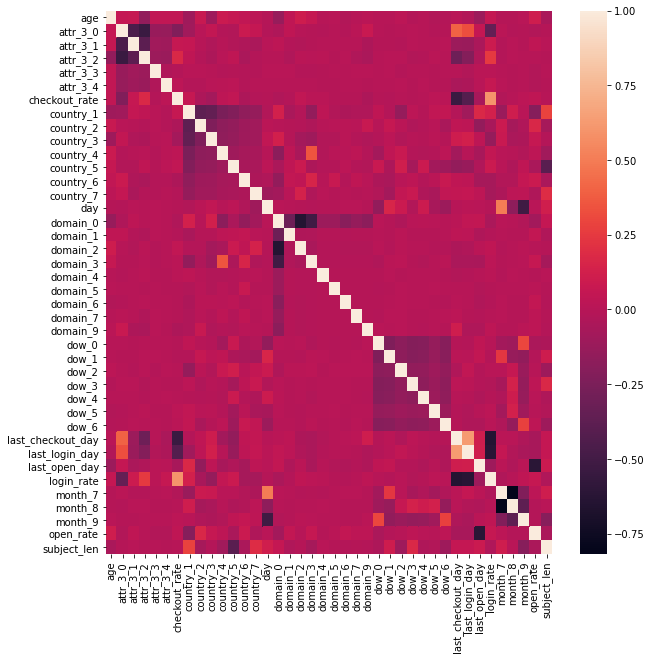

In [9]:
corr_mat = train_df_final.drop("open_flag", axis = 1).corr()
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr_mat, ax = ax)

In [10]:
scaler = StandardScaler()

x_train = train_df_final.drop("open_flag", axis = 1).to_numpy()
y_train = train_df_final["open_flag"].to_numpy()
x_cols = train_df_final.drop("open_flag", axis = 1).columns

x_train = scaler.fit_transform(x_train)
x_train

array([[ 0.0747407 ,  1.28220045, -0.57952047, ..., -0.32031767,
        -0.65212045,  0.05217069],
       [ 0.0747407 ,  1.28220045, -0.57952047, ..., -0.32031767,
        -0.18138342, -0.4842231 ],
       [-0.23790727, -0.80538297,  1.79130493, ..., -0.32031767,
         1.59427808, -0.03722828],
       ...,
       [-0.40213866, -0.80538297, -0.57952047, ..., -0.32031767,
         0.06046769, -1.02061688],
       [ 0.0747407 ,  1.28220045, -0.57952047, ..., -0.32031767,
        -0.63967739, -0.12662724],
       [-1.467494  , -0.80538297,  0.07266925, ..., -0.32031767,
        -0.752408  ,  1.21435722]])

# Training

In [11]:
valid_df_final = clean_data(valid_df, users_df_clean)
valid_df_final = engineer_features(valid_df_final, is_valid = True)
valid_df_final

,age,attr_3_0,attr_3_1,attr_3_2,attr_3_3,attr_3_4,checkout_rate,country_1,country_2,country_3,country_4,country_5,country_6,country_7,day,domain_0,domain_1,domain_2,domain_3,domain_4,domain_5,domain_6,domain_7,domain_9,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,last_checkout_day,last_login_day,last_open_day,login_rate,month_7,month_8,month_9,open_flag,open_rate,subject_len
0,5.000000,1,0,0,0,0,0.021480,0,0,1,0,0,0,0,23,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.643856,3.584963,9.652845,0.124328,1,0,0,0,0.000000,39
1,4.754888,0,0,1,0,0,0.079520,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.584963,1.584963,6.614710,1.007196,0,0,1,0,0.000000,33
2,4.954196,0,1,0,0,0,0.182692,0,1,0,0,0,0,0,21,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3.459432,1.584963,5.882643,1.808042,1,0,0,0,0.009586,43
3,4.700440,0,0,1,0,0,0.000000,0,1,0,0,0,0,0,18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6.303781,3.700440,2.000000,0.180572,1,0,0,1,0.567221,52
4,5.000000,1,0,0,0,0,0.000000,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.473706,4.459432,9.652845,0.021480,0,1,0,0,0.201634,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18380,5.000000,1,0,0,0,0,0.000000,0,1,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,10.473706,6.044394,2.321928,0.000000,0,0,1,1,0.438293,38
18381,4.754888,0,0,1,0,0,0.271027,0,0,1,0,0,0,0,14,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.321928,1.000000,1.584963,2.135863,0,1,0,0,0.425817,42
18382,5.087463,0,0,1,0,0,0.296702,1,0,0,0,0,0,0,17,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.807355,1.000000,5.954196,1.335331,1,0,0,0,0.000000,52
18383,5.129283,0,0,1,0,0,0.117695,1,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,4.000000,2.584963,2.807355,1.025029,0,0,1,0,0.469886,33


In [12]:
x_valid = valid_df_final.drop("open_flag", axis = 1).to_numpy()
y_valid = valid_df_final["open_flag"].to_numpy()
x_valid = scaler.transform(x_valid)
x_valid

array([[ 0.0747407 ,  1.28220045, -0.57952047, ..., -0.32031767,
        -0.752408  , -0.39482413],
       [-0.74831176, -0.80538297, -0.57952047, ...,  3.12790001,
        -0.752408  , -0.93121792],
       [-0.07906149, -0.80538297,  1.79130493, ..., -0.32031767,
        -0.70209818, -0.03722828],
       ...,
       [ 0.36842832, -0.80538297, -0.57952047, ..., -0.32031767,
        -0.752408  ,  0.7673624 ],
       [ 0.50885444, -0.80538297, -0.57952047, ...,  3.12790001,
         1.71366295, -0.93121792],
       [ 1.61744588, -0.80538297, -0.57952047, ...,  3.12790001,
         0.85594801, -0.93121792]])

Train - 0.7633 - Valid - 0.5337


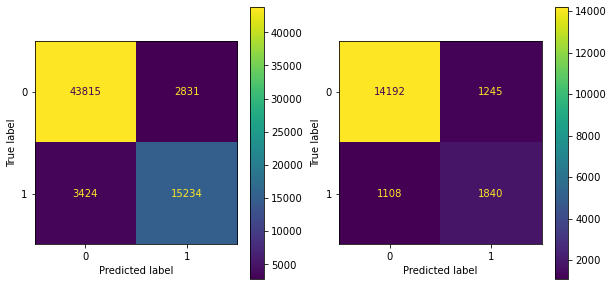

In [13]:
model_rf1 = RandomForestClassifier(
    n_estimators = 536,
    min_samples_split = 62,
    min_samples_leaf = 4,
    max_depth = 20,
    random_state = 42,
    n_jobs = -1,
    class_weight = {0: 1, 1: 1.35},
    max_features = None
)
model_rf1.fit(x_train, y_train)
print("Train - {:.4f} - Valid - {:.4f}".format(
    matthews_corrcoef(y_train, model_rf1.predict(x_train)),
    matthews_corrcoef(y_valid, model_rf1.predict(x_valid)))
)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plot_confusion_matrix(model_rf1, x_train, y_train, ax = ax[0])
plot_confusion_matrix(model_rf1, x_valid, y_valid, ax = ax[1])

Train - 0.7518 - Valid - 0.5357


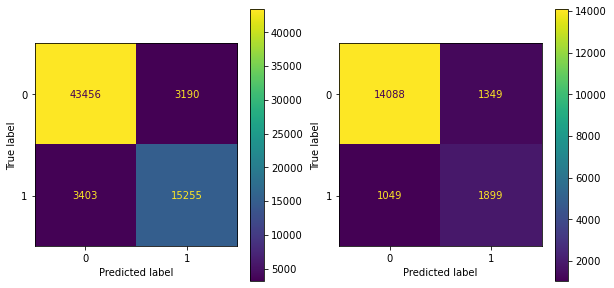

In [14]:
model_et1 = ExtraTreesClassifier(
    n_estimators = 536,
    min_samples_split = 62,
    min_samples_leaf = 4,
    max_depth = 20,
    random_state = 42,
    n_jobs = -1,
    class_weight = {0: 1, 1: 1.35},
    max_features = None
)
model_et1.fit(x_train, y_train)
print("Train - {:.4f} - Valid - {:.4f}".format(
    matthews_corrcoef(y_train, model_et1.predict(x_train)),
    matthews_corrcoef(y_valid, model_et1.predict(x_valid)))
)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plot_confusion_matrix(model_et1, x_train, y_train, ax = ax[0])
plot_confusion_matrix(model_et1, x_valid, y_valid, ax = ax[1])

Train - 0.7929 - Valid - 0.5349


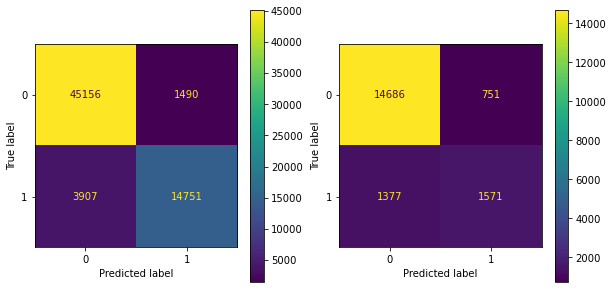

In [15]:
model_gb1 = GradientBoostingClassifier(
    n_estimators = 280,
    min_samples_split = 400,
    min_samples_leaf = 50,
    max_depth = 13,
    random_state = 42,
    max_features = None,
    learning_rate = 0.025,
    subsample = 0.8
)
model_gb1.fit(x_train, y_train)
print("Train - {:.4f} - Valid - {:.4f}".format(
    matthews_corrcoef(y_train, model_gb1.predict(x_train)),
    matthews_corrcoef(y_valid, model_gb1.predict(x_valid)))
)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plot_confusion_matrix(model_gb1, x_train, y_train, ax = ax[0])
plot_confusion_matrix(model_gb1, x_valid, y_valid, ax = ax[1])

Train - 0.7696 - Valid - 0.5382


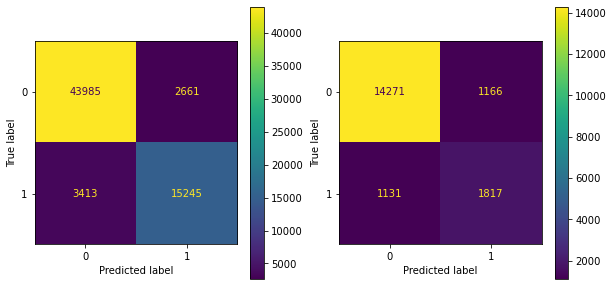

In [16]:
model_all = VotingClassifier(
    estimators=[
        ("rf1", model_rf1),
        ("et1", model_et1),
        ("gb1", model_gb1),
    ],
    n_jobs= -1,
    verbose = 2
)

model_all.fit(x_train, y_train)
print("Train - {:.4f} - Valid - {:.4f}".format(
    matthews_corrcoef(y_train, model_all.predict(x_train)),
    matthews_corrcoef(y_valid, model_all.predict(x_valid)))
)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plot_confusion_matrix(model_all, x_train, y_train, ax = ax[0])
plot_confusion_matrix(model_all, x_valid, y_valid, ax = ax[1])

# Predicting

In [17]:
test_df_final = clean_data(test_df, users_df_clean)
test_df_final = engineer_features(test_df_final, is_valid = True)
test_df_final

,age,attr_3_0,attr_3_1,attr_3_2,attr_3_3,attr_3_4,checkout_rate,country_1,country_2,country_3,country_4,country_5,country_6,country_7,day,domain_0,domain_1,domain_2,domain_3,domain_4,domain_5,domain_6,domain_7,domain_9,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,last_checkout_day,last_login_day,last_open_day,login_rate,month_7,month_8,month_9,open_rate,subject_len
0,5.000000,1,0,0,0,0,0.226509,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3.807355,1.584963,4.807355,1.337235,0,0,1,0.165644,35
1,5.000000,1,0,0,0,0,0.000000,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,8.584963,2.584963,3.000000,0.321928,0,0,1,0.070389,35
2,5.087463,0,0,1,0,0,0.137504,0,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.000000,1.000000,5.129283,0.900464,0,0,1,0.000000,25
3,4.523562,0,0,1,0,0,0.195348,1,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2.584963,2.584963,6.000000,2.193772,0,0,1,0.000000,36
4,5.000000,1,0,0,0,0,0.019109,0,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.781360,2.584963,2.807355,0.584963,0,0,1,0.000000,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,5.000000,1,0,0,0,0,0.000000,0,0,0,0,0,1,0,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.169925,2.321928,9.668885,0.000000,0,0,1,0.000000,53
55966,5.000000,1,0,0,0,0,0.000000,0,0,0,0,0,1,0,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.238405,9.649256,5.906891,0.000000,0,0,1,0.009586,53
55967,5.000000,1,0,0,0,0,0.000000,0,0,0,0,0,1,0,29,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,10.515700,3.000000,9.668885,0.000000,0,0,1,0.000000,43
55968,5.000000,1,0,0,0,0,0.000000,0,0,0,0,0,1,0,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.807355,2.584963,2.584963,0.000000,0,0,1,0.269033,43


In [18]:
x_test = test_df_final.to_numpy()
x_test = scaler.transform(x_test)
x_test

array([[ 0.0747407 ,  1.28220045, -0.57952047, ...,  3.12790001,
         0.11693028, -0.75241999],
       [ 0.0747407 ,  1.28220045, -0.57952047, ...,  3.12790001,
        -0.38298842, -0.75241999],
       [ 0.36842832, -0.80538297, -0.57952047, ...,  3.12790001,
        -0.752408  , -1.64640963],
       ...,
       [ 0.0747407 ,  1.28220045, -0.57952047, ...,  3.12790001,
        -0.752408  , -0.03722828],
       [ 0.0747407 ,  1.28220045, -0.57952047, ...,  3.12790001,
         0.65954056, -0.03722828],
       [ 0.0747407 ,  1.28220045, -0.57952047, ...,  3.12790001,
         1.61276795,  0.85676136]])

In [19]:
pred = model_all.predict(x_test)
pred

array([0, 0, 0, ..., 0, 0, 1])

In [20]:
output_df = pd.DataFrame({
    "row_id": test_df_final.index,
    "open_flag": pred
})
output_df = output_df.astype(int)
output_df

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [21]:
print(pd.concat([train_df, valid_df])["open_flag"].value_counts(normalize = True))
print(output_df["open_flag"].value_counts(normalize = True))

0    0.844219
1    0.155781
Name: open_flag, dtype: float64
0    0.857692
1    0.142308
Name: open_flag, dtype: float64


In [22]:
# output_df.to_csv("./data/submission.csv", index = False)